In [200]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [201]:
import sys

sys.path.append("..")

import torch
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import griddata

seed = 256
torch.manual_seed(seed)
np.random.seed(seed)

## Plotting Utilities

In [202]:
from matplotlib.patches import Rectangle

def plot_hypercubes(ax, hypercubes: torch.Tensor, color="C0", alpha=0.4):
    for h in hypercubes:
        low, high = h[:, 0], h[:, 1]
        side_lengths = high - low

        patch = Rectangle(low, side_lengths[0], side_lengths[1], facecolor=color, alpha=alpha)
        ax.add_patch(patch)

def plot_as_heatmap(ax, x, y, z, n_points=1000, cmap="viridis", norm=None, interpolation="linear"):
    x_min, x_max = min(x), max(x)
    y_min, y_max = min(y), max(y)
    X, Y = np.meshgrid(np.linspace(x_min, x_max, n_points), np.linspace(y_min, y_max, n_points))
    Z = griddata((x, y), z, (X, Y), method=interpolation)
    pcm = ax.imshow(Z, extent=[x_min, x_max, y_min, y_max], origin="lower", cmap=cmap, norm=norm)
    return pcm

## Data Generation

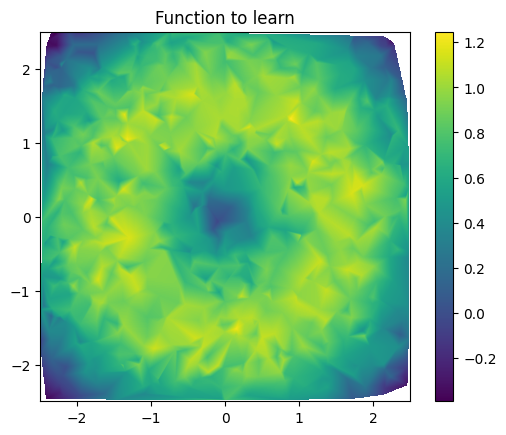

In [203]:
from torch_mas.data import DataBuffer

num_samples = 1000
test_size = 1000
num_features = 2
noise_level = 0.1
X = (torch.rand(num_samples, num_features)-0.5)*5
y = (torch.sin(torch.sqrt(X[:, 0]**2 + X[:, 1]**2)) + torch.randn(X.size(0))*noise_level).unsqueeze(-1)
X_test = (torch.rand(num_samples, num_features)-0.5)*5
y_test = (torch.sin(torch.sqrt(X_test[:, 0]**2 + X_test[:, 1]**2))).unsqueeze(-1)
dataset = DataBuffer(X, y)

X.shape, y.shape

fig = plt.gcf()
ax = plt.gca()
# pcm = plot_as_heatmap(ax, X_test[:, 0], X_test[:, 1], y_test)
pcm = plot_as_heatmap(ax, X[:, 0], X[:, 1], y)
ax.set_title("Function to learn")
fig.colorbar(pcm)

## Model Training

In [204]:
import time
from torch_mas.batch.batch_head import BatchHead
from torch_mas.batch.agents.batch_agents_linear_reg import BatchLinearAgent

model = BatchHead(
    dataset.input_dim,
    dataset.output_dim,
    R=0.5,
    imprecise_th=0.01,
    bad_th=0.1,
    alpha=0.1,
    memory_length=10,
    n_epochs=1,
    batch_size=64,
    l1=0.1,
    agents=BatchLinearAgent
)

t = time.time()
model.fit(dataset)
tt = time.time() - t
print(f"Total training time: {tt}s")

print("Number of agents created:", model.agents.n_agents)

Total training time: 0.2883288860321045s
Number of agents created: 168


In [205]:
for i, h in enumerate(model.agents.hypercubes):
    print(i, h)

0 tensor([[0.6345, 1.1345],
        [0.4376, 0.9376]], grad_fn=<UnbindBackward0>)
1 tensor([[-1.3640, -0.8897],
        [ 1.4376,  1.9120]], grad_fn=<UnbindBackward0>)
2 tensor([[-0.5704, -0.0704],
        [-0.6265, -0.1265]], grad_fn=<UnbindBackward0>)
3 tensor([[-1.8512, -1.3512],
        [-0.6742, -0.1742]], grad_fn=<UnbindBackward0>)
4 tensor([[-1.9860, -1.4860],
        [-1.6586, -1.1586]], grad_fn=<UnbindBackward0>)
5 tensor([[-1.7359, -1.3090],
        [-0.0467,  0.4229]], grad_fn=<UnbindBackward0>)
6 tensor([[1.4802, 1.9777],
        [1.7171, 2.2643]], grad_fn=<UnbindBackward0>)
7 tensor([[-2.7014, -2.2014],
        [-0.6201, -0.1201]], grad_fn=<UnbindBackward0>)
8 tensor([[-2.5563, -2.1063],
        [ 0.6031,  1.0531]], grad_fn=<UnbindBackward0>)
9 tensor([[-0.6048, -0.1779],
        [-2.4502, -1.9806]], grad_fn=<UnbindBackward0>)
10 tensor([[ 0.8143,  1.3143],
        [-1.0884, -0.5884]], grad_fn=<UnbindBackward0>)
11 tensor([[-2.1360, -1.6617],
        [ 0.2510,  0.7254]], g

### Agents Visualization

Text(0, 0.5, 'Y')

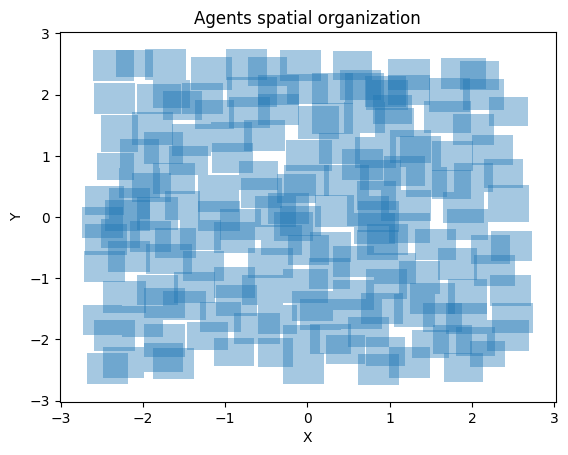

In [206]:
ax = plt.gca()
ax.scatter(dataset.X[:, 0], dataset.X[:, 1], marker="o", c="r", alpha=0)
plot_hypercubes(ax, model.agents.hypercubes.detach().numpy())
ax.set_title("Agents spatial organization")
ax.set_xlabel("X")
ax.set_ylabel("Y")

### Predictions Visualization

Total Prediction time: 0.01131749153137207s for 1000 samples
Prediction time per sample: 1.131749153137207e-05s
Mean Squared Error: 0.010727383


Text(0.5, 1.0, 'Predictions on test')

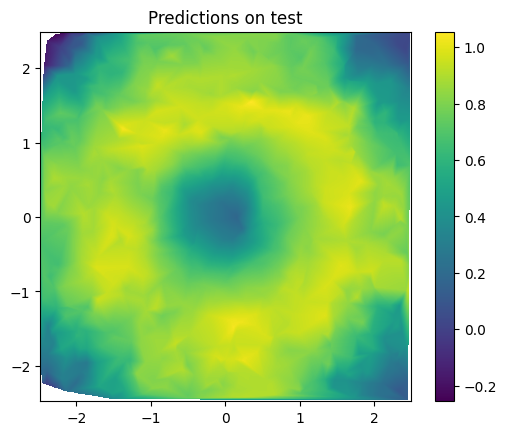

In [207]:
import time

t = time.time()
y_pred = model.predict(X_test)
tt = time.time() - t
tps = tt / X_test.size(0)
print(f"Total Prediction time: {tt}s for {X_test.size(0)} samples")
print(f"Prediction time per sample: {tps}s")

mse = ((y_pred - y_test) ** 2).mean()
print("Mean Squared Error:", mse.detach().numpy())

fig = plt.gcf()
ax = plt.gca()
pcm = plot_as_heatmap(ax, X_test[:, 0], X_test[:, 1], y_pred.detach().squeeze(), interpolation="linear", n_points=1000)
fig.colorbar(pcm)
ax.set_title("Predictions on test")